# Siamese Similarity

**Authors:** Itamar Zaltsman<br>
**Date created:** 2021/06/12<br>
**Description:** Detecting same objects by embedding vectors and evaluating model performance.

## Introduction
We have two matrices to represent products: 
- image embedding matrix: each row is an embedding vector of item image.
- text embedding matrix: each row is an embedding vector of item text.

For each product we would like to find all matching products that are in the dataset under the assumption:
- Each product has a least one match
- there are no more than 50 matches by product

## Setup

In [1]:
import pandas as pd
import numpy as np
from numpy import genfromtxt
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
from tqdm.notebook import tqdm
from sklearn.neighbors import NearestNeighbors

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Load embedding matrices

In [3]:
image_embeddings_dir = '/content/drive/MyDrive/ITC/final_project/Shopee/data/train_img_emb.csv'
X_emb_dir = '/content/drive/MyDrive/ITC/final_project/Shopee/data/X_emb_data.csv'

img_emb = genfromtxt(image_embeddings_dir, delimiter=',')
X = pd.read_csv(X_emb_dir)

In [4]:
X.shape, img_emb.shape

((2000, 7), (2000, 1024))

## Prepare target labels

In the original data each product have a group label. Our model output is all matches by item. The code below creates true matches in order to evaluate the model performance.

In [5]:
def get_matches(y, grouped_data):
    """ returns list of all matches by item
    """
    
    matches = []
    for i in range(len(y)):
        g = y.iloc[i]
        labels = list(grouped_data.get_group(g).posting_id)
        matches.append(labels)
    
    return matches

In [6]:
# preparing true matches (y_true)

grouped_data = X.groupby('label_group')
matches_true = get_matches(X['label_group'], grouped_data)


## Evaluation

The project evaluation metric is mean f1-score. The mean is calculated in a sample-wise fashion, meaning that an F1 score is calculated for every predicted row, then averaged.

In [7]:
def get_f1_score(pred, y_true):
    """returns mean F1 score. The mean is calculated in a sample-wise fashion, 
        meaning that an F1 score is calculated for every predicted row, then averaged.
    """
    
    true_p = []
    false_n = []
    false_p = []
    
    for i in tqdm(range(len(pred))):
        
        p = pred[i]
        p_true = y_true[i]
        
        tp = len(set(p) & set(p_true)) - 1
        fp = len(np.setdiff1d(p, p_true))
        fn = len(np.setdiff1d(p_true, p))
        
        false_p.append(fp)
        false_n.append(fn)
        true_p.append(tp)

    df = pd.DataFrame({"tp":true_p, "fp":false_p, "fn":false_n})
    df["f1"] = df.tp / (df.tp + 0.5*(df.fp + df.fn))
    df["precision"] = df.tp / (df.tp + df.fp)
    df["recall"] = df.tp / (df.tp + df.fn)

    return df
    

## Predict Matches

Goal: for each item in the dataset find all matches.

Approch:
- using KNN with 51 neighbours to find the nearest 50 items.
- each neighbour that falls within the treshold is a a match

We know that each item has at least one match, so in case of no matches: set the nearest neighbour as a match if it falls below an upper threshold.<br>

_Threshold:_ the value of threshold is the value that maximized the f1-score over the validation data.

_Upper threshold:_ is the mean distance of the first element + 2 times the standard deviation.

In [8]:
k_neighbors = 51

nbrs = NearestNeighbors(n_neighbors=k_neighbors, algorithm='ball_tree').fit(img_emb)

distances, indices = nbrs.kneighbors(img_emb)

In [9]:
thresh = 0.95
upper_thresh = 3
posting_ids = X['posting_id'].values

pred = []

for i in tqdm(range(len(indices))):
    
    tresh_filt = distances[i] < thresh
    match_indices = indices[i, tresh_filt]
    pred.append(posting_ids[match_indices].tolist())
    
    if (tresh_filt.sum()) == 1 and (distances[i, 1] < upper_thresh):
        pred[i].append(posting_ids[indices[i, 1]])

## Results

In [10]:
# Presenting results

df = get_f1_score(pred, matches_true)
df['1st distance'] = distances[:, 1]
df['2nd distance'] = distances[:, 2]
df['3rd distance'] = distances[:, 3]
df['4th distance'] = distances[:, 4]
df.describe().round(2)

,tp,fp,fn,f1,precision,recall,1st distance,2nd distance,3rd distance,4th distance
count,2000.00,2000.00,2000.00,2000.00,2000.00,2000.00,2000.00,2000.00,2000.00,2000.00
mean,1.55,0.56,1.97,0.50,0.62,0.47,0.70,0.91,0.99,1.04
std,2.23,1.35,3.11,0.43,0.47,0.43,0.44,0.37,0.33,0.29
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.00,0.00,0.00,0.00,0.00,0.00,0.23,0.85,0.99,1.05
50%,1.00,0.00,1.00,0.57,1.00,0.50,0.87,1.09,1.12,1.14
75%,2.00,1.00,2.00,1.00,1.00,1.00,1.10,1.16,1.17,1.18
max,13.00,18.00,21.00,1.00,1.00,1.00,1.27,1.27,1.28,1.28


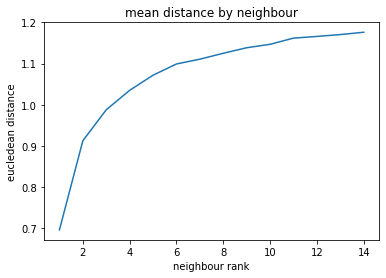

In [11]:
sns.lineplot(x=range(1,15), y=distances[:, 1:15].mean(axis=0))
plt.title("mean distance by neighbour")
plt.xlabel("neighbour rank")
plt.ylabel("eucledean distance");

In [12]:
# upper threshold estimation
distances[:,1].std() * 2 + distances[:,1].mean()

1.5771587434044303

## Prediction code for deployment
to be used for single item prediction (get matches)

In [ ]:
# one sample prediction (used for deployment)

from sklearn.neighbors import NearestNeighbors
import numpy as np
from numpy import genfromtxt

path_to_dir = '/content/train_images/'
file_path = 'vgg2.csv'
image_embeddings_dir = '/content/drive/MyDrive/ITC/final_project/Shopee/data/siamese_image_embedding' + file_path
X_emb_dir = '/content/drive/MyDrive/ITC/final_project/Shopee/data/siamese_data' + file_path

img_emb = genfromtxt(image_embeddings_dir, delimiter=',')
X = pd.read_csv(X_emb_dir)


posting_ids = X['posting_id'].values
thresh = 0.2
k_neighbors = 51

X.set_index('posting_id', inplace=True)

nbrs = NearestNeighbors(n_neighbors=k_neighbors, algorithm='ball_tree').fit(img_emb)
distances, indices = nbrs.kneighbors(img_emb)

def predict_matches(input_posting_id, distances, indices, X):
  """ Returns matches for given posting id
  """

  input_idx = np.where(posting_ids==input_posting_id)[0][0]
  tresh_filt = distances[input_idx] < thresh
  match_indices = indices[input_idx, tresh_filt]
  matches_posting_ids = (posting_ids[match_indices].tolist())

  if tresh_filt.sum() == 1:
      matches_posting_ids.append(posting_ids[indices[i, 1]])

  matches_posting_ids.remove(input_posting_id)

  return X.loc[matches_posting_ids, :]

In [ ]:
# test
input_posting_id = 	'train_119714892'

get_matches(input_posting_id, distances, indices, X)

## Summary
Using VGG16 as a base model with one layer of embedding and 10 epochs training we achieved f1-score of 0.51.<br>
ResNet50 based model gave f1-score of 0.4. <br>